In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook
from tqdm import tqdm
import pandas as pd
import os
import cv2
import sys
import scipy



%matplotlib inline

Using TensorFlow backend.


In [2]:
bad_path = 'DataSets/Bad50x50/27733/'
left_path = 'DataSets/LeftHand50x50/27731/'
rigth_path = 'DataSets/RightHand50x50/27730/'
test_path = 'DataSets/Test189x110/27734/'

In [3]:
dir_path = [bad_path, left_path, rigth_path]

In [4]:

train_img_path = []
for i in dir_path :
    image_in_dir = []
    for j in os.listdir(i):
        if j.split('.')[1] == 'jpg':
            image_in_dir.append(i + j)
    train_img_path.append(image_in_dir)

In [5]:
target_list = [0, 1, 2]

In [6]:
train_data = []
train_target = []
for paths, target in zip(train_img_path, target_list):
    for path in paths:
        train_data.append(imread(path, mode='L'))
        train_target.append(target)
train_data = np.array(train_data)
train_target = np.array(train_target)

In [7]:
test_img_path = []
for i in os.listdir(test_path):
    if i.split('.')[1] == 'jpg':
        test_img_path.append(test_path + i)

In [8]:
test_data = []
for path in test_img_path:
    test_data.append(imread(path, mode='L', ))
test_data = np.array(test_data)

In [9]:
batch_size, img_rows, img_cols = 64 , 50, 50

In [10]:
input_shape = (img_rows, img_cols, 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target)

In [12]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

In [13]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [14]:
datagen_train = ImageDataGenerator(
    rotation_range=180, zoom_range=0.1)
datagen_train.fit(X_train.reshape(-1, 50, 50, 1))
datagen_test = ImageDataGenerator(
    rotation_range=180, zoom_range=0.1)
datagen_test.fit(X_test.reshape(-1, 50, 50, 1))

In [15]:
Y_train = np_utils.to_categorical(y_train, 3)
Y_test = np_utils.to_categorical(y_test, 3)

In [16]:
model = Sequential([
    Conv2D(32, (5, 5), input_shape=input_shape, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding ='same'),
    Conv2D(64, (5, 5), input_shape=input_shape, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding = 'same'),
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dropout(0.5),
    Dense(3),
    Activation('softmax')
])

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
res = model.fit_generator(
    datagen_train.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    validation_data=datagen_test.flow(X_test, Y_test, batch_size=32),
    validation_steps = len(X_test) / 32,
    epochs=200, 
    verbose=1)

Epoch 1/200
53/52 [==============================] - 91s 2s/step - loss: 0.7231 - acc: 0.6025 - val_loss: 0.5618 - val_acc: 0.6649
Epoch 2/200
53/52 [==============================] - 85s 2s/step - loss: 0.5304 - acc: 0.7225 - val_loss: 0.3955 - val_acc: 0.8441
Epoch 3/200
53/52 [==============================] - 87s 2s/step - loss: 0.4032 - acc: 0.8183 - val_loss: 0.2931 - val_acc: 0.8925
Epoch 4/200
53/52 [==============================] - 85s 2s/step - loss: 0.2472 - acc: 0.8944 - val_loss: 0.1678 - val_acc: 0.9427
Epoch 5/200
53/52 [==============================] - 85s 2s/step - loss: 0.2147 - acc: 0.9101 - val_loss: 0.1732 - val_acc: 0.9480
Epoch 6/200
53/52 [==============================] - 86s 2s/step - loss: 0.1449 - acc: 0.9481 - val_loss: 0.1203 - val_acc: 0.9462
Epoch 7/200
53/52 [==============================] - 86s 2s/step - loss: 0.1359 - acc: 0.9449 - val_loss: 0.0745 - val_acc: 0.9749
Epoch 8/200
53/52 [==============================] - 99s 2s/step - loss: 0.0852 - a

53/52 [==============================] - 67s 1s/step - loss: 0.0053 - acc: 0.9976 - val_loss: 0.0234 - val_acc: 0.9964
Epoch 64/200
53/52 [==============================] - 66s 1s/step - loss: 0.0056 - acc: 0.9982 - val_loss: 3.6969e-04 - val_acc: 1.0000
Epoch 65/200
53/52 [==============================] - 67s 1s/step - loss: 0.0032 - acc: 0.9988 - val_loss: 0.0044 - val_acc: 0.9982
Epoch 66/200
53/52 [==============================] - 76s 1s/step - loss: 0.0182 - acc: 0.9959 - val_loss: 0.0068 - val_acc: 0.9982
Epoch 67/200
53/52 [==============================] - 85s 2s/step - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0178 - val_acc: 0.9946
Epoch 68/200
53/52 [==============================] - 75s 1s/step - loss: 0.0025 - acc: 0.9988 - val_loss: 4.3315e-04 - val_acc: 1.0000
Epoch 69/200
53/52 [==============================] - 83s 2s/step - loss: 0.0025 - acc: 0.9988 - val_loss: 0.0025 - val_acc: 0.9982
Epoch 70/200
53/52 [==============================] - 86s 2s/step - loss: 0.0123 

53/52 [==============================] - 88s 2s/step - loss: 7.2807e-04 - acc: 1.0000 - val_loss: 3.3292e-04 - val_acc: 1.0000
Epoch 125/200
53/52 [==============================] - 89s 2s/step - loss: 0.0012 - acc: 1.0000 - val_loss: 6.7403e-04 - val_acc: 1.0000
Epoch 126/200
53/52 [==============================] - 86s 2s/step - loss: 0.0047 - acc: 0.9976 - val_loss: 0.0013 - val_acc: 0.9982
Epoch 127/200
53/52 [==============================] - 93s 2s/step - loss: 0.0047 - acc: 0.9982 - val_loss: 3.8474e-04 - val_acc: 1.0000
Epoch 128/200
53/52 [==============================] - 86s 2s/step - loss: 0.0017 - acc: 0.9994 - val_loss: 0.0041 - val_acc: 0.9982
Epoch 129/200
53/52 [==============================] - 90s 2s/step - loss: 3.0190e-04 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 130/200
53/52 [==============================] - 88s 2s/step - loss: 6.2115e-04 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9982
Epoch 131/200
53/52 [==============================] - 87s 

53/52 [==============================] - 83s 2s/step - loss: 0.0085 - acc: 0.9976 - val_loss: 4.4079e-04 - val_acc: 1.0000
Epoch 185/200
53/52 [==============================] - 85s 2s/step - loss: 0.0038 - acc: 0.9988 - val_loss: 0.0056 - val_acc: 0.9964
Epoch 186/200
53/52 [==============================] - 90s 2s/step - loss: 0.0075 - acc: 0.9976 - val_loss: 0.0173 - val_acc: 0.9982
Epoch 187/200
53/52 [==============================] - 88s 2s/step - loss: 0.0087 - acc: 0.9982 - val_loss: 3.7886e-04 - val_acc: 1.0000
Epoch 188/200
53/52 [==============================] - 86s 2s/step - loss: 0.0058 - acc: 0.9988 - val_loss: 0.0139 - val_acc: 0.9964
Epoch 189/200
53/52 [==============================] - 67s 1s/step - loss: 2.5671e-04 - acc: 1.0000 - val_loss: 3.9244e-04 - val_acc: 1.0000
Epoch 190/200
53/52 [==============================] - 68s 1s/step - loss: 2.7845e-04 - acc: 1.0000 - val_loss: 1.7408e-05 - val_acc: 1.0000
Epoch 191/200
53/52 [==============================] - 73s 

In [70]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
df = pd.DataFrame(res.history)

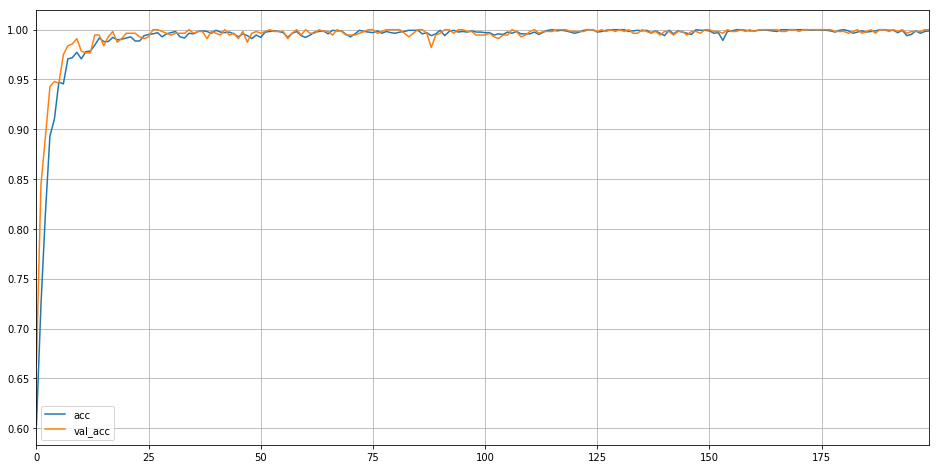

In [22]:
df[['acc', 'val_acc']].plot(figsize=(16, 8))
plt.grid(True);

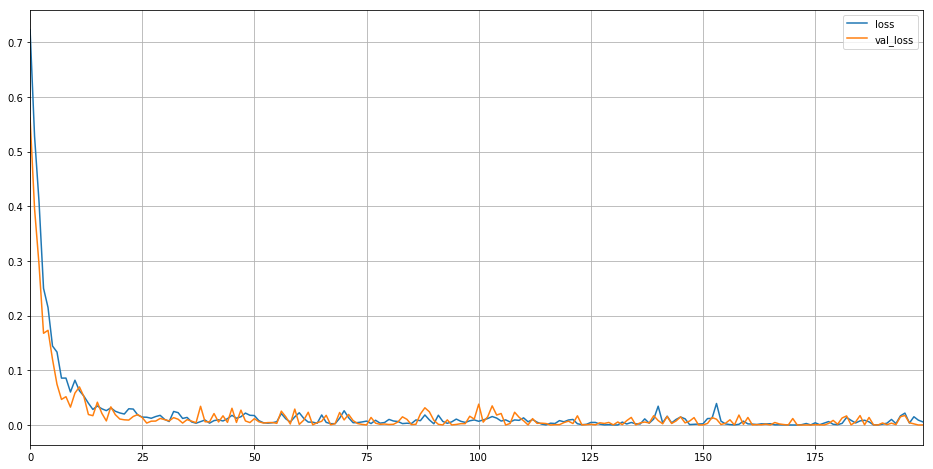

In [23]:
df[['loss', 'val_loss']].plot(figsize=(16, 8))
plt.grid(True);

In [49]:
mod_img = []
value = (15, 15)
l = 0
left = 0
right = 0
rand_img = np.random.randint(0, 30, (50, 50))
for img in tqdm_notebook(test_data):
    blur = cv2.GaussianBlur(img, value, 0)
    _, thresh1 = cv2.threshold(blur, 127, 255,
                               cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    im2, contours, hierarchy = cv2.findContours(thresh1, 
                                                cv2.RETR_TREE,
                                                cv2.CHAIN_APPROX_SIMPLE)
    img_rect = img.copy()
    for i in contours:
        x, y, w, h = cv2.boundingRect(i)
        if (x, y) == (0, 0) or not 30 < w < 50 or not 30 < h < 50:
            continue
        
        x_plus = (50 - w) // 2
        y_plus = (50 - h) // 2
    
        crop_img = np.copy(rand_img)
        crop_img[y_plus:h+y_plus, x_plus:w+x_plus] = img[y:y+h, x:x+w]
        pred = np.round(model.predict(crop_img.reshape(-1,50, 50,1)))
        
        if np.all(pred == np.array([[0., 1., 0.]])):
            img_rect = cv2.rectangle(img_rect, (x,y), (x+w,y+h),255,1) 
            img_rect = cv2.putText(img_rect.copy(), 
                                        'left', 
                                        (x, y-1),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.4,255)
            left += 1
        if np.all(pred == np.array([[0., 0., 1.]])):
            img_rect = cv2.rectangle(img_rect, (x,y), (x+w,y+h),255,1)
            img_rect = cv2.putText(img_rect.copy(), 
                                        'right', 
                                        (x,y-1),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.4,255)
            right += 1 
                
    
    mod_img.append(img_rect)
    l += 1
print('\nTotal number of img: {}'.format(l))
print('Number of left hands: {}'.format(left))
print('Number of right hands: {}'.format(right))

A Jupyter Widget



Total number of img: 934
Number of left hands: 450
Number of right hands: 405


In [44]:
name_dir = 'updated_img'

In [51]:
os.mkdir(name_dir)

In [52]:
os.chdir(name_dir)

In [53]:
for i in tqdm_notebook(range(len(mod_img))):
    plt.imsave(str(i)+'.png', mod_img[i], cmap='gray')

A Jupyter Widget

In [ ]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")